<h1>
    <center>
    TMA4215 Project 2


### Table of contents
#### 1. Introduction
#### 2. Algorithm 
#### 3. Deciding parameters

3.1 The batchsize 

3.2 The number of hidden layers, $K$

3.3 The value of the learning parameter, $\tau$

3.4 The dimension of the input data in the hidden layers $d$

3.5 The stepsize $h$

3.6 Conclusion


#### 4. Training and testing with suggested functions
4.1 $F(y) = 1-\cos(y)$

4.2 $G(y_1, y_2) = \frac{1}{2}(y_1^2 + y_2^2)$

4.3 Known Hamiltonian

4.3 Unknown Hamiltonian

#### 5. Determine the gradient 


### 1. Introduction

The purpose of this project is to use a neural network to train approximations of Hamiltonian function, derive and implement formulas for computing the gradient of the trained function and use those to implement symplectic Euler and the Størmer-Verlet method for the Hamiltonian function. 

This report starts with presenting the training algorithm and arguing for the choices of the parameters $K$, $\tau$, $d$ ang $h$ used in this algorithm. Furthermore, the training prosedure is implemented for known functions and Hamiltonians and the efficienty of this training is determined by comparing the values obtained by using the trained weights and biases to the accurate function values. For unknown Hamiltonian.... The report brifly determine a formula for computing of gradients and define the symplectic Euler and Størmer-Verlet method. ...




In [1]:
import numpy as np
import matplotlib.pyplot as plt
from math import isclose
from mpl_toolkits.mplot3d import Axes3D

In [2]:
from project_2_data_acquisition import generate_data, concatenate
from files import writeParams, readParams

The functions above are imported from separate files and are used to generate input data batches from comma seperated files and to write our trained values to a file as well as reading these values from a file. 

### 2. Algorithm

The algorithm is divided into several smaller codeblocks with the purpose of making the code easy to follow. Principally, the algorithm's parts is to transform input data between the layers in the network, decide the gradients of the objective function, $J = \frac{1}{2} \|Z-c\| $, with respect to weights, biases, $\omega$ and $\mu$ and optimalize the network with respect to those. Additionally, several utility functions is defined to be used in the algorithm.

In [3]:
def getW(K,d):
    w = np.random.randn(K,d,d)
    return w

def getb(K,d):
    b = np.random.randn(K,d,1)
    return b

def getomega(d):
    omega = np.random.randn(d,1)
    return omega

def getmu():
    mu = np.random.randn(1)
    return mu

The functions above generate random initial values, drawn from a standard normal distribution, to the weights, $W_k$, the biases, $b_k$, $\omega$ and $\mu$. These random values causes some marginal differences between runs of the same dataset. 

In [4]:
def sigma(x):
    return np.tanh(x)

def sigma_div(x):
    return 1 - np.tanh(x)**2

def eta(x):
    return 1/2*(1+np.tanh(x/2))

def eta_div(x):
    return 1/(4*np.cosh(x/2)**2) 

Above, the activating function $\sigma$, which is used in the transformation $\Phi_k: Z_k \rightarrow Z_{k+1}$, and the function $\eta$, used in projection from last layer on a scalar $z$, is defined. The derivatives of $\sigma$ and $\eta$ is also defined and will be used in calculations of the gradient of the objective function.

In [5]:
def getZ(Y0, W, b, K, d, I, h, sigma):
    #initialize Z, Z0=Y0
    Z = np.zeros((K+1,d,I))
    Z[0] = Y0

    #finds Zk
    for k in range(1,K+1):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def getP(Z, ypsilon, c, omega, mu, W, b, K, d, I, h, sigma_div, eta_div):
    #initialize P
    P = np.zeros((K+1,d,I))

    #finds P_K
    u = np.transpose(Z[-1])@omega + mu
    P[-1]= omega@np.transpose((ypsilon-c)*eta_div(u))

    #finds P_K-1 to P_0
    for k in range(K-1,0,-1):
        s = W[k]@Z[k] + b[k]
        P[k]=P[k+1] + h*np.transpose(W[k])@(sigma_div(s)*P[k+1])
        
    return P


def getYpsilon(Z, omega, mu, K, eta):
    u = np.transpose(Z[K]) @ omega + mu
    return eta(u)

def getJ(ypsilon, c):
    return 1/2 * np.linalg.norm(ypsilon-c)**2

Defines the functions getZ and getP, where getZ executes linear transformations $\Phi_k: Z_k \rightarrow Z_{k+1}$ based on the weights and biases and returns the matrix $Z$ and getP returns an utility matrix used in calulations of derivatives of the objective function with respect to the weight and biases. Furthermore, getYpsilon is defined and returns a vector of the function values in the last layer of the network and the objective funksjon $J$ is defined as a measure of the difference between the resulting trained values and the exact function values. 

In [6]:
def getdJdmu(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K])@omega + mu
    dJdmu = np.transpose(eta_div(u))@(ypsilon-c)
    return dJdmu

def getdJdomega(Z, ypsilon, c, omega, mu, K, eta_div):
    u = np.transpose(Z[K])@omega + mu
    dJdOmega = Z[K] @ ((ypsilon - c) * eta_div(u))
    return dJdOmega

def getdJdW(P, Z, W, b, K, h, sigma_div):
    dJdW = np.zeros_like(W)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdW[k] = h*(P[k+1]*sigma_div(u))@ np.transpose(Z[k])  
    return dJdW

def getdJdb(P, Z, W, b, K, h, sigma_div):
    dJdb = np.zeros_like(b)
    for k in range(K):
        u = W[k]@Z[k]+b[k]
        dJdb[k] = h*(P[k+1]*sigma_div(u))@np.ones((Z.shape[2],1))
    return dJdb

Functions to obtain the derivatives of the objective function with respect to weights and biased is defined. 

In [7]:
def plain(theta, tau, dJdtheta):
    return theta - tau*dJdtheta

def adam(theta,alpha,m,v,g,i):
    #parameters
    beta1 = 0.9
    beta2 = 0.999
    epsilon = 10E-8

    #m,v
    m = beta1*m + (1-beta1)*g
    v = beta2*v + (1-beta2)*np.multiply(g,g)

    m_hat = np.multiply(m,1/(1-beta1**i))
    v_hat = np.multiply(v,1/(1-beta2**i))

    #update
    R = alpha*np.multiply(m_hat,1/(np.sqrt(v_hat)+epsilon))

    return theta-R,m,v

def getMandV(theta):
    return np.zeros_like(theta),np.zeros_like(theta)

The functions above is used to optimize the weights, biases, $\omega$ and $\mu$ in different ways, which will be compared later on in this report.

In plain vanilla gradient descent, one follows the gradient in decreasing direction and the learning parameter $\tau$ determine how far one shall follow it. 

In Adam descent method, one follows the gradient with different length depending on different parameters. The parameters $m$ and $v$ represent respectively a kind of mean value and squared mean value of the previous iterations gradients. The function getMandV initialize $m$ and $v$ to be either zero, the zerovector or the zeromatrix depending on inputdata's dimension. 

In [8]:
def scale(x, alpha=0.2, beta=0.8):
    a = np.amin(x)
    b = np.amax(x)
    
    x_tilde = 1/(b-a)*((b-x)*alpha + (x-a)*beta)
    return x_tilde, a, b

def inverseScale(x_tilde, a, b, alpha=0.2, beta=0.8):
    return 1/(beta-alpha)*((x_tilde-alpha)*b + (beta-x_tilde)*a)

A function to scale inputdata in terms of a min-max transformation, which guarantees that the data have all its components in the interval $[\alpha, \beta]$, is defined. This is desirable since some functions is acting component-wise on other functions....?

In [23]:
def successrate(ypsilon, c, tol,I):
    ypsilon.resize((1,I))
    c.resize((1,I))
    
    s = 0
    acc = 0
    
    for i in range(I):
        d = np.abs(ypsilon[0,i]-c[0,i])
        acc += d
        if d <= tol:
            s +=1
    return s/I, acc/I

si noe fornuftig her etterhver

c og yps forskjellig shape

In [10]:
def trainingAlgorithm(K, d, h, tau, Y0, c0, eta, sigma, eta_div, sigma_div, N, tol, chunksize, optimization):
    #finds input shape
    d0 = Y0.shape[0]
    I0 = Y0.shape[1]
    
    #reshapes input to match dimension of layers
    if d0 > d:
        print("d must be larger than d0")
    
    if d0 < d:
        zero = np.zeros((d-d0,I0))
        Y0 = np.vstack((Y0,zero))
    
    #gets initial weigths
    omega = getomega(d)
    mu = getmu()
    W = getW(K,d)
    b = getb(K,d)
    
    c0 = np.transpose(c0)
  
    if optimization == "adam":
        #initial m,v for adam descent
        mmu,vmu = getMandV(mu)
        momega,vomega =getMandV(omega)
        mW,vW = getMandV(W)
        mb,vb = getMandV(b)
    
    #initializes vector to store objective function values
    J = np.zeros(N)
    ypsilon = np.zeros_like(c0)
    
    for i in range(N):
               
        #stochastic gradient descent
        if I0 == chunksize:
            Y0_chunk = Y0
            c_chunk = c0
        elif I0 > chunksize:
            s = np.random.randint(0,I0-chunksize)
            Y0_chunk = Y0[:,s:(s+chunksize)]
            c_chunk=c0[s:(s+chunksize),:]
        else:
            print("chunksize must be smaller than I")       
        

        #transformations between layers
        Z = getZ(Y0_chunk, W, b, K, d, chunksize, h, sigma)
        ypsilon = getYpsilon(Z, omega, mu, K, eta)
        P = getP(Z, ypsilon, c_chunk, omega, mu, W, b, K, d, chunksize, h, sigma_div, eta_div)
        
        #objective function
        J[i] = getJ(ypsilon, c_chunk)
        
        #finds gradients
        dJdmu = getdJdmu(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdomega = getdJdomega(Z, ypsilon, c_chunk, omega, mu, K, eta_div)
        dJdW = getdJdW(P, Z, W, b, K, h, sigma_div)
        dJdb = getdJdb(P, Z, W, b, K, h, sigma_div)
        
        if optimization == "plain":
            mu = plain(mu, tau, dJdmu)
            omega = plain(omega, tau, dJdomega)
            W = plain(W, tau, dJdW)
            b = plain(b, tau, dJdb)
        
        elif optimization == "adam":
            mu, mmu,vmu = adam(mu,tau,mmu,vmu,dJdmu,i+1)
            omega, momega,vomega = adam(omega,tau,momega,vomega,dJdomega,i+1)
            W, mW,vW = adam(W,tau,mW,vW,dJdW,i+1)
            b, mb,vb = adam(b,tau,mb,vb,dJdb,i+1)
        
        if (J[i]/chunksize) < tol:
            break
        
    return mu, omega, W, b, J, ypsilon, i

The training algorithm returns trained values of the weights, biases, $\omega$ and $\mu$ as well as the objective function and $\Upsilon$. 

In [11]:
def testingAlgorithm(yTest, W, b, omega, mu, K, d, I, h, sigma, eta, a_scale, b_scale):
    
    #scaling y
    yTilde, ay, by = scale(yTest)
    
    #finds input shape
    d0 = yTest.shape[0]
    
    if d > d0:
        zero = np.zeros((d-d0,I))
        yTilde = np.vstack((yTilde,zero))
    
    zTest = getZ(yTilde, W, b, K, d, I, h, sigma)
    ypsilonTilde = getYpsilon(zTest, omega, mu, K, eta)

    #rescaling of input
    ypsilonTest = inverseScale(ypsilonTilde, a_scale, b_scale)

    return ypsilonTest

si litt om testingsalgoritma

### 3. Deciding parameters

In [ ]:
from decidingParameters import filenameList, plotParams

In [ ]:
batch0 = generate_data(0)

p0_tilde ap0, bp0 = scale(batch0['P'])
T0_tilde, aT0, bT0 = scale(batch0['T'])
T0_tilde.resize(1,T0_tilde.shape[0])

N = 5000
tol = 1E-10 
I_0 = p0_tilde.shape[1]
batchsize = I_0
d_0 = p0_tilde.shape[0]    
h = 0.1     
tau = 0.001  
K = 50

In this section, optimal choices for the parameters $K$, $\tau$, $d$ and $h$ will be investigated. All the following tests are based on the first batch of values, enclosed to the project description, for the unknown Hamiltonian function. The number for training series is chosen to be 5000 for all the tests, as it makes it possible to illustrate the development of each parameter's impact on the training process. The tolerance is set sufficiently small so that one can guarantee that the training algorithm does not obtain a tolerated value for the objective function within the 5000 training series. 

The initial values of the parameters is set to be $K = 50$, $\tau = 0.001$, $d = 3$ and $h =0.1$. After each investigation the value of the current parameter will be updated to the investigated optimal choice and the updated value is used in the remaining tests.

The investigations include graphs for both implementation of the adam descent and plain vanilla gradient descent, but our choices of parameters will in all cases be made based on Adam descent, knowing this method is more efficient than plain vanilla gradient descent. 

#### 3.1 The batchsize

In [ ]:
#define variables for this test
batchsize_list = np.arange(I_0/4, I_0+1,I_0/4).astype(int) 

filenames_batchsize_A, filenames_batchsize_P = filenameList(batchsize_list, "batch")

In [ ]:
for i in range(len(batchsize_list)):
    batchsize = batchsize_list[i]
    #train for different batchsizes with adam descent 
    mu_A0, omega_A0, W_A0, b_A0, J_Abatch, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Abatch, itr_A0, filename = filenames_batchsize_A[i])
    
    #train for different batchsizes with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_Pbatch, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Pbatch, itr_P0, filename = filenames_batchsize_P[i])

In [ ]:
plotParams(batchsize_list, "batch")

The graphs illustrate that the use of stochastic gradient descent makes the objective function oscillates around a minimum. The smaller the batchsize, the more oscillations?? For half the batchsize, in this case $2048$, these oscillations are about one order of magnitude and after $N=4000$ training series the value of the objective function is of magnitude $10^{-4}$. Since a smaller batchsize will reduce the run-time, will we use the stochastic gradient descent in cases with large original inputsize and use about half of the total inputdatasize as inputdata for the training process. For full batchsize, the objective function converges to its minimum. This is favourable for the investigations of the parameters $K$, $\tau$ and $d$ (since ??) and full batchsize will therefore be used in the investigations in this section. 



#### 3.2 The number of hidden layers, $K$

In [ ]:
#define variables for this test   
K_list = np.arange(25,101,25) 

#define lists of filenames where the trained parameters will be stored
filenames_K_A, filenames_K_P = filenameList(K_list, "K")

In [ ]:
for i in range(len(K_list)):
    K = K_list[i]
    #train for different K values with adam descent
    mu_A0, omega_A0, W_A0, b_A0, J_AK, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_AK, itr_A0, filename = filenames_K_A[i])
    
    #train for different K values with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_PK, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_PK, itr_P0, filename = filenames_K_P[i])

In [ ]:
plotParams(K_list, "K")

As illustrated above, the different number of hidden layers seems to behave relatively similar for training on this inputdata. Therefore $K=50$ is chosen as an optimal value, both with respect to the fact that it looks like the best option from the graph and due to the small differences between the number of layers it is not desireable to choose a larger numbers since it will increase the running time substantially. 

#### 3.3 The value of the learning parameter $\tau$

In [ ]:
#define variables for this test
tau_list = np.linspace(0.001, 0.01, 4)   #learning parameter

#define lists of filenames where the trained parameters will be stored
filenames_tau_A, filenames_tau_P = filenameList(tau_list, "tau")

In [ ]:
for i in range(len(tau_list)):
    tau = tau_list[i]

    #train for different tau values with adam descent
    mu_A0, omega_A0, W_A0, b_A0, J_Atau, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Atau, itr_A0, filename = filenames_tau_A[i])
    
    #train for different tau values with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_Ptau, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Ptau, itr_P0, filename = filenames_tau_P[i])

In [ ]:
plotParams(tau_list, "tau")

By observing the graph, the optimal value of the learning parameter is chosen to be $\tau = 0.004$.

#### 3.4 The dimension of the input data in the hidden layers $d$

In [ ]:
d_0_list = np.array([3,4,5,6])  

#define lists of filenames where the trained parameters will be stored
filenames_d_A, filenames_d_P = filenameList(d_0_list, "d")

In [ ]:
for i in range(len(d_0_list)):
    d0 = d_0_list[i]
    
    #train for different values of d with adam descent
    mu_A0, omega_A0, W_A0, b_A0, J_Ad0, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Ad0, itr_A0, filename = filenames_d_A[i])
    
    #train for different values of d with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_Pd0, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Pd0, itr_P0, filename = filenames_d_P[i])

In [ ]:
plotParams(d_0_list, "d")

The graphs illustrate that the value of the objective function will have spikes in the cases where the dimension of the inputdata in the hidden layers is $d=3$, $d=5$ and $d=6$, and these spikes which can give values greater than the value for $d=4$. The dimension of the input data in the hidden layers is therefore chosen to be $d=4$ (where the input data originally has the dimension $d_0 = 3$). 

#### 3.5 The stepsize $h$

In [ ]:
h_list = np.array([0.05, 0.1, 0.15, 0.2])

#define lists of filenames where the trained parameters will be stored
filenames_h_A, filenames_h_A = filenameList(h_list, "h")

In [ ]:
for i in range(len(h_list)):
    h = h_list[i]
    #train for different stepsizes h with adam descent
    mu_A0, omega_A0, W_A0, b_A0, J_Ah1, ypsilon_A0, itr_A0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
    writeParams(W_A0, b_A0, omega_A0, mu_A0, ypsilon_A0, J_Ah1, itr_A0, filename = filenames_h_A[i])
    
    #train for different stepsizes h with plain vanilla gradient descent
    mu_P0, omega_P0, W_P0, b_P0, J_Ph1, ypsilon_P0, itr_P0 = trainingAlgorithm(K, d_0, h, tau, p0_tilde, T0_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "plain")
    writeParams(W_P0, b_P0, omega_P0, mu_P0, ypsilon_P0, J_Ph1, itr_P0, filename = filenames_h_P[i])

In [ ]:
plotParams(h_list, "h")

All the different values of the stepsize seems to behave relatively similar for the first 2500 training series, if the number of training series exceeds this number, its seems to be spikes that can be due to overfitting?? The optimal value of the stepsize is chosen to be $h=0.1$, since ... hopefully the training will obtain a tolerated value of the objective function within the first 3000 training series, and the overfitting problem will not occur??????????? feilen er veldig lav, er det bra eller dårliG??

#### 3.6 Conclusion 

-grafene viser at adam er bedre enn plain overalt

-valg av verdier oppsumert

-om man skulle vist den endelige objective function grafen med disse verdiene??

### 4. Training and testing with suggested functions

In [12]:
#defines global variables for all the following tests
h = 0.2       #stepsize
tau = 0.004   #learning parameter
tol = 1e-5  #tolerance
N = 5000      #number of training series
K = 50        #number of hidden layers

#### 4.1  $F(y) = 1-\cos{y}$

In [13]:
def F(y):
    return 1-np.cos(y)

In [32]:
#define variable used for training with F(y)
d_F = 2        
I_F = 1500 

#define and scale input data ....AND FASIT
Y0_F = np.random.uniform(-2,2,(1,I_F))
c_F = F(Y0_F)
Y0_F_tilde aY_f, bY_F =scale(Y0_F)
c_F_tilde, ac_F, bc_F = scale(c_F)

In [ ]:
#training for F(y)
mu_F, omega_F, W_F, b_F, J_F, ypsilon_F, itr_F = trainingAlgorithm(K, d_F, h, tau, Y0_F_tilde, c_F_tilde, eta, sigma, eta_div, sigma_div, N, tol, I_F, "adam")

#stores the trained parameters in file
writeParams(W_F, b_F, omega_F, mu_F,ypsilon_F, J_F, itr_F, filename = 'trainingParams_F.txt')

In [15]:
#read the stored trained parameters
W_F,b_F,omega_F,mu_F,ypsilon_F, J_F, itr_F = readParams(K, d_F, I_F, N, filename='trainingParams_F.txt')

In [ ]:
#
plt.plot(np.linspace(0,itr_F,itr_F), J_F[:itr_F]/I_F)
plt.yscale('log')
plt.show()

Cellen over gjøres om til en funkjson

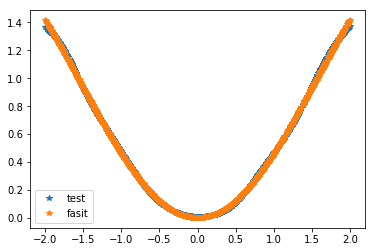

In [34]:
#testing with F(y)
YTest_F = np.random.uniform(-2,2,(1,I_F))
cTest_F = F(YTest_F)


ypsilonTest_F = testingAlgorithm(YTest_F, W_F, b_F, omega_F, mu_F, K, d_F, I_F, h, sigma, eta, ac_F, bc_F)

plt.figure()
plt.plot(YTest_F[0], ypsilonTest_F[:,0], "*", label = "test")
plt.plot(YTest_F[0], cTest_F[0], "*", label = "fasit")
plt.legend()
plt.show()

In [41]:
successrate_F, accuracy_F = successrate(ypsilonTest_F, cTest_F, 10**(-2), I_F)
print(successrate_F)
print(accuracy_F)

0.766
0.00837781057345


#### 4.2 $G(y_1,y_2) = \frac{1}{2} (y_1^2 + y_2^2)$

In [42]:
def G(y1, y2):
    return 1/2 *(y1**2 + y2**2)

In [43]:
#define variable used for training with G(y)
d_G = 4       
I_G = 100    

#training with G(y)
Y0_G = np.random.uniform(-2,2,(2,I_G))
c_G = G(Y0_G[0],Y0_G[1])
c_G.resize(1,I_G)

Y0_G_tilde = Y0_G
c_G_tilde, ac_G, bc_G = scale(c_G)

In [ ]:
#training for G(y)
mu_G, omega_G, W_G, b_G, J_G, ypsilon_G, itr_G = trainingAlgorithm(K, d_G, h, tau, Y0_G_tilde, c_G_tilde, eta, sigma, eta_div, sigma_div, N, tol, I_G, "adam")
writeParams(W_G, b_G, omega_G, mu_G, ypsilon_G, J_G, itr_G, filename = 'trainingParams_G.txt')

In [44]:
W_G, b_G, omega_G, mu_G, ypsilon_G, J_G, itr_G = readParams(K, d_G, I_G, N, filename='trainingParams_G.txt')

In [ ]:
#plotting of objective function
plt.plot(np.linspace(0,itr_G,itr_G), J_G[:itr_G]/I_G)
plt.yscale("log")
plt.show()

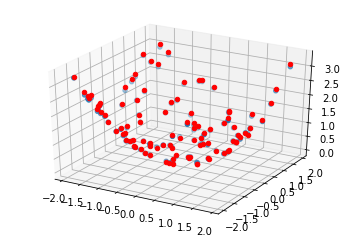

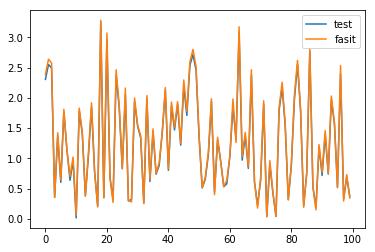

In [46]:
#testing with G(y)
YTest_G = np.random.uniform(-2,2,(2,I_G))
cTest_G = G(YTest_G[0], YTest_G[1])
cTest_G.resize(1,I_G)

ypsilonTest_G = testingAlgorithm(YTest_G, W_G, b_G, omega_G, mu_G, K, d_G, I_G, h, sigma, eta, ac_G, bc_G)


#plotting of G(y)
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')
ax.scatter(YTest_G[0], YTest_G[1], ypsilonTest_G, label = "test", depthshade = True)
ax.scatter(YTest_G[0], YTest_G[1], cTest_G[0], label = "test" , c="red", depthshade = False)
plt.show()

x = np.arange(0, I_G)
plt.plot(x, ypsilonTest_G, label ="test")
plt.plot(x, cTest_G[0], label = "fasit")
plt.legend()
plt.show()

#### 4.3 Known Hamiltonian 

In [ ]:
def T_Kepler(p):
    T_p = np.zeros((1,p.shape[1]))
    for i in range(p.shape[1]):
        T_p[:,i] = 1/2*np.transpose(p[:,i])@p[:,i]
    return T_p

def V_Kepler(q1,q2):
    return -1/np.sqrt(q1**2+q2**2)

In [ ]:
I_K = 1500
d_K = 4

In [ ]:
p_K = np.random.uniform(0,10, (2,I_K))
T_K = T_Kepler(p_K)
T_K_tilde, aTK, bTK = scale(T_K)

q_K = np.random.uniform(0.01,10, (2,I_K))
V_K = V_Kepler(q_K[0],q_K[1])
V_K.resize(1,I_K)
V_K_tilde, aVK, bVK = scale(V_K)

In [ ]:
#Training T
mu_TK, omega_TK, W_TK, b_TK, J_TK, ypsilon_TK, itr_TK = trainingAlgorithm(K, d_K, h, tau, p_K, T_K_tilde, eta, sigma, eta_div, sigma_div, N, tol, I_K, "adam")
writeParams(W_TK, b_TK, omega_TK, mu_TK, ypsilon_TK, J_TK, itr_TK, filename = 'trainingParams_TKepler.txt')

#Training V
mu_VK, omega_VK, W_VK, b_VK, J_VK, ypsilon_VK, itr_VK = trainingAlgorithm(K, d_K, h, tau, q_K, V_K_tilde, eta, sigma, eta_div, sigma_div, N, tol, I_K, "adam")
writeParams(W_VK, b_VK, omega_VK, mu_VK, ypsilon_VK, J_VK, itr_VK, filename = 'trainingParams_VKepler.txt')

In [ ]:
W_TK,b_TK,omega_TK,mu_TK, ypsilon_TK, J_TK, itr_TK = readParams(K, d_K, I_K, N, filename='trainingParams_TKepler.txt')
W_VK,b_VK,omega_VK,mu_VK, ypsilon_VK, J_VK, itr_VK = readParams(K, d_K, I_K, N, filename='trainingParams_VKepler.txt')

#### 4.4 Unknown Hamiltonian

In [ ]:
trainingBatch = concatenate(0,25)

In [ ]:
dT = trainingBatch['P'].shape[0]
IT = trainingBatch['P'].shape[1]
batchsize = 50000

pT_tilde = trainingBatch['P']
TT_tilde, aTT, bTT = scale(trainingBatch['T'])
TT_tilde.resize(1,TT_tilde.shape[0])

In [ ]:
mu_T, omega_T, W_T, b_T, J_T, ypsilon_T, itr_T = trainingAlgorithm(K, dT, h, tau, pT_tilde, TT_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
writeParams(W_T, b_T, omega_T, mu_T, ypsilon_T, J_T, itr_T, filename = 'trainingParams_T.txt')

In [ ]:
W_T, b_T, omega_T, mu_T, ypsilon_T, J_T, itr_T = readParams(K, dT, batchsize, N, filename='trainingParams_T.txt')

In [ ]:
#plotting of objective function
plt.plot(np.linspace(0,itr_T,itr_T), J_T[:itr_T]/batchsize)
plt.yscale("log")
plt.show()

In [ ]:
I_T = trainingBatch["Q"].shape[1]
d_T = 4
batchsize = 50000

qT_tilde = trainingBatch["Q"]
VT_tilde, aVT, bVT = scale(trainingBatch["V"])
VT_tilde.resize(1,VT_tilde.shape[0])

In [ ]:
mu_VT, omega_VT, W_VT, b_VT, J_VT, ypsilon_VT, itr_VT = trainingAlgorithm(K, d_T, h, tau, qT_tilde, VT_tilde, eta, sigma, eta_div, sigma_div, N, tol, batchsize, "adam")
writeParams(W_VT, b_VT, omega_VT, mu_VT, ypsilon_VT, J_VT, itr_VT, "trainingParams_Vd4riktigtau.txt")

In [ ]:
W_VT,b_VT,omega_VT,mu_VT, ypsilon_VT, J_VT, itr_VT = readParams(K, d_T, batchsize, N, filename='trainingParams_Vd4riktigtau.txt')

### 5. Computing the gradient 

In [ ]:
def getZ_oneData(y,W,b,K,h,sigma):
    d = y.shape[0]
    I = y.shape[1]
    Z = np.zeros((K,d,I))
    Z[0] = y
    
    for k in range(1,K):
        u = W[k-1]@Z[k-1] + b[k-1]
        Z[k] = Z[k-1] + h*sigma(u)

    return Z

def gradF(y, omega, mu, W, b, K, sigma, eta_div, sigma_div):
    Z = getZ_oneData(y, W, b, K, h, sigma)
    A = eta_div(np.transpose(Z[K-1])@omega + mu)*omega 
    for k in range(K-1,0,-1): 
        B = h*sigma_div(W[k]@y+b[k])
        u = B*A
        A = A + W[k]@u
    return A

### 6. Numerical methods 

In [ ]:
def symplecticEuler(gradF, t, q0, p0, omega_V, mu_V, W_V, b_V, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div): 

    q = np.zeros((len(t), q0.shape[0], q0.shape[1]))
    p = np.zeros((len(t), p0.shape[0], p0.shape[1]))
    
    q[0] = q0
    p[0] = p0
    
    for n in range(len(t)-1):
        delta_t = t[n+1]-t[n] 

        q[n+1] = q[n] + delta_t*gradF(p[n], omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div) #dTdp
        p[n+1] = p[n] - delta_t*gradF(q[n+1], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #dVdq
    
    return q,p

In [ ]:
def Stromer_Verlet(gradF, t, q0, p0, omega_V, mu_V, W_V, b_V, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div): 
    
    q = np.zeros((len(t), q0.shape[0], q0.shape[1]))
    p = np.zeros((len(t), p0.shape[0], p0.shape[1]))
    
    q[0] = q0
    p[0] = p0
    
    for n in range(len(t)-1):
        delta_t = t[n+1]-t[n]
        
        u = p[n] - delta_t/2*gradF(q[n], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #u = p_{n+1/2}, dVdq
        q[n+1] = q[n] + delta_t*gradF(u, omega_T, mu_T, W_T, b_T, K, sigma, eta_div, sigma_div) #dTdp
        p[n+1] = u - delta_t/2*gradF(q[n+1], omega_V, mu_V, W_V, b_V, K, sigma, eta_div, sigma_div) #dVdq
    
    return q,p

#### 6.1 Nonlinear pendulum

In [ ]:
I_p = 1000
d_p = 2

q_p = np.random.uniform(0,2*np.pi,(1,I_p))
V_p = V_pend(q_p)
V_p_tilde, aVp, bVp = scale(V_p)

In [ ]:
W_Tpend,b_Tpend,omega_Tpend,mu_Tpend,ypsilon_Tpend, J_Tpend, itr_Tpend = readParams(K, d_p, I_p, N, filename='trainingParams_Tp.txt')
W_Vpend,b_Vpend,omega_Vpend,mu_Vpend,ypsilon_Vpend, J_Vpend, itr_Vpend = readParams(K, d_p, I_p, N, filename='trainingParams_Vp.txt')

In [ ]:
q0 = np.zeros((d_p,1))
p0 = np.zeros((d_p,1))
t = np.linspace(0,10,100)

q_sympEuler, p_sympEuler = symplecticEuler(gradF, t, q0, p0, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, omega_Tpend, mu_Tpend, W_Tpend, b_Tpend, K, sigma, eta_div, sigma_div)

q_StromerVerlet, p_StromerVerlet = Stromer_Verlet(gradF, t, q0, p0, omega_Vpend, mu_Vpend, W_Vpend, b_Vpend, omega_Tpend, mu_Tpend, W_Tpend, b_Tpend, K, sigma, eta_div, sigma_div)

In [ ]:
q_plot = np.append(np.flip(q_sympEuler[:,0,:]),q_sympEuler[:,1,:])

q = np.linspace(-2,2,100)

plt.plot(q, V_pend(q), label = "fasit")
plt.plot(q_plot, V_pend(q_plot), "--", label = "Symplectic Euler")


plt.legend()


In [ ]:
q_plot = np.append(np.flip(q_StromerVerlet[:,0,:]),q_StromerVerlet[:,1,:])

q = np.linspace(-2,2,100)

plt.plot(q, V_pend(q), label = "fasit")
plt.plot(q_plot, V_pend(q_plot), "--", label = "Stromer Verlet")


plt.legend()
